In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time, warnings, pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

from edward.models import Normal, Dirichlet, InverseGamma, ParamMixture, Bernoulli
plt.style.use('ggplot')
warnings.simplefilter('ignore')

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
def build_toy_dataset(data_file):
#     features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
#     df = pd.read_csv('./train-winequality-white.csv', sep=';')
#     X = df[features].values
#     y = (df.quality >= 7).values #.astype(np.float32)
    df = pd.read_csv(data_file)
    X = df.iloc[:,:-1].astype(np.float32)
    y = df.iloc[:,-1].astype(np.float32)
    # 标准化处理
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X).astype(np.float32)
    return X, y

def neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(X, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    #h = tf.sigmoid(tf.matmul(h, W_2) + b_2)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

def pack_theta( W_0, W_1, W_2, b_0, b_1, b_2):
    pW_0 = np.reshape(W_0, [-1])
    pW_1 = np.reshape(W_1, [-1])
    pW_2 = np.reshape(W_2, [-1])
    pb_0 = np.reshape(b_0, [-1])
    pb_1 = np.reshape(b_1, [-1])
    pb_2 = np.reshape(b_2, [-1])
    return np.concatenate((pW_0, pW_1, pW_2, pb_0, pb_1, pb_2), axis=0)

In [4]:
ed.set_seed(42)
# DATA
reg_pre = 'PM2.5_'
train_file = './data/'+reg_pre+'train.csv'
test_file = './data/'+reg_pre+'test.csv'
X_train, Y_train = build_toy_dataset(train_file) #真实数据
X_test, Y_test = build_toy_dataset(test_file)
N, D = X_train.shape
print(N, D)
layer_size = [D, 7, 10, 1]

105384 9


In [5]:
# MODEL
'''
W_0 = Normal(loc=tf.zeros([D, 7]), scale=10 * tf.ones([D, 7]),name="W_0")
W_1 = Normal(loc=tf.zeros([7, 10]), scale=10 * tf.ones([7, 10]), name="W_1")
W_2 = Normal(loc=tf.zeros([10, 1]), scale=10 * tf.ones([10, 1]), name="W_2")
b_0 = Normal(loc=tf.zeros(7), scale=10 * tf.ones(7), name="b_0")
b_1 = Normal(loc=tf.zeros(10), scale=10 * tf.ones(10), name="b_1")
b_2 = Normal(loc=tf.zeros(1), scale=10 * tf.ones(1), name="b_2")
'''
C = 2
with tf.variable_scope("W_0"):
    #probs = tf.ones([D,7,C]) / 5.0
    #params = {'loc': tf.zeros([C,D,7]), 'scale': tf.ones([C,D,7])}
    #W_0 = ParamMixture(probs, params, Normal)
    probs = Dirichlet(tf.ones([D, 7, C]))
    mu = Normal(tf.zeros([D, 7]), tf.ones([D, 7]), sample_shape=C)
    sigmasq = InverseGamma(tf.ones([D, 7]), tf.ones([D, 7]), sample_shape=C)
    W_0 = ParamMixture(probs, {'loc': mu, 'scale': 10*tf.sqrt(sigmasq)}, Normal)
with tf.variable_scope("W_1"):
    probs = Dirichlet(tf.ones([7, 10, C]))
    mu = Normal(tf.zeros([7, 10]), tf.ones([7, 10]), sample_shape=C)
    sigmasq = InverseGamma(tf.ones([7, 10]), tf.ones([7, 10]), sample_shape=C)
    W_1 = ParamMixture(probs, {'loc': mu, 'scale': 10*tf.sqrt(sigmasq)}, Normal)
with tf.variable_scope("W_2"):
    probs = Dirichlet(tf.ones([10, 1, C]))
    mu = Normal(tf.zeros([10, 1]), tf.ones([10, 1]), sample_shape=C)
    sigmasq = InverseGamma(tf.ones([10, 1]), tf.ones([10, 1]), sample_shape=C)
    W_2 = ParamMixture(probs, {'loc': mu, 'scale': 10*tf.sqrt(sigmasq)}, Normal)
with tf.variable_scope("b_0"):
    probs = Dirichlet(tf.ones([7, C]))
    mu = Normal(tf.zeros(7), tf.ones(7), sample_shape=C)
    sigmasq = InverseGamma(tf.ones(7), tf.ones(7), sample_shape=C)
    b_0 = ParamMixture(probs, {'loc': mu, 'scale': 10*tf.sqrt(sigmasq)}, Normal)
with tf.variable_scope("b_1"):
    probs = Dirichlet(tf.ones([10, C]))
    mu = Normal(tf.zeros(10), tf.ones(10), sample_shape=C)
    sigmasq = InverseGamma(tf.ones(10), tf.ones(10), sample_shape=C)
    b_1 = ParamMixture(probs, {'loc': mu, 'scale': 10*tf.sqrt(sigmasq)}, Normal)
with tf.variable_scope("b_2"):
    probs = Dirichlet(tf.ones([1, C]))
    mu = Normal(tf.zeros(1), tf.ones(1), sample_shape=C)
    sigmasq = InverseGamma(tf.ones(1), tf.ones(1), sample_shape=C)
    b_2 = ParamMixture(probs, {'loc': mu, 'scale': 10*tf.sqrt(sigmasq)}, Normal)

X = tf.placeholder(tf.float32, [None, D], name="X")
# regression
#Y_sigma = Normal(loc=0.0, scale=10, name='Y_sigma')
y_ = tf.placeholder(tf.float32, [None], name = "y_placeholder")
Y = Normal(loc=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2), scale=0.1, name="Y") #broadcast the scale
# classification
#y_ = tf.placeholder(tf.int32, [None], name = "y_placeholder")
#Y = Bernoulli(probs=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2), name="Y")

In [6]:
# INFERENCE FRAMEWORK
with tf.variable_scope("qW_0"):
    probs = tf.get_variable("probs", [D, 7, C], initializer=tf.constant_initializer(1.0 / C))
    mu = tf.get_variable("loc", [C, D, 7])
    sigma = tf.nn.softplus(tf.get_variable("scale", [C, D, 7]))
    qW_0 = ParamMixture(probs, {'loc': mu, 'scale': sigma}, Normal)
with tf.variable_scope("qW_1"):
    probs = tf.get_variable("probs", [7, 10, C], initializer=tf.constant_initializer(1.0 / C))
    mu = tf.get_variable("loc", [C, 7, 10])
    sigma = tf.nn.softplus(tf.get_variable("scale", [C, 7, 10]))
    qW_1 = ParamMixture(probs, {'loc': mu, 'scale': sigma}, Normal)
with tf.variable_scope("qW_2"):
    probs = tf.get_variable("probs", [10, 1, C], initializer=tf.constant_initializer(1.0 / C))
    mu = tf.get_variable("loc", [C, 10, 1])
    sigma = tf.nn.softplus(tf.get_variable("scale", [C, 10, 1]))
    qW_2 = ParamMixture(probs, {'loc': mu, 'scale': sigma}, Normal)
with tf.variable_scope("qb_0"):
    probs = tf.get_variable("probs", [7, C], initializer=tf.constant_initializer(1.0 / C))
    mu = tf.get_variable("loc", [C, 7])
    sigma = tf.nn.softplus(tf.get_variable("scale", [C, 7]))
    qb_0 = ParamMixture(probs, {'loc': mu, 'scale': sigma}, Normal)
with tf.variable_scope("qb_1"):
    probs = tf.get_variable("probs", [10, C], initializer=tf.constant_initializer(1.0 / C))
    mu = tf.get_variable("loc", [C, 10])
    sigma = tf.nn.softplus(tf.get_variable("scale", [C, 10]))
    qb_1 = ParamMixture(probs, {'loc': mu, 'scale': sigma}, Normal)
with tf.variable_scope("qb_2"):
    probs = tf.get_variable("probs", [1, C], initializer=tf.constant_initializer(1.0 / C))
    mu = tf.get_variable("loc", [C, 1])
    sigma = tf.nn.softplus(tf.get_variable("scale", [C, 1]))
    qb_2 = ParamMixture(probs, {'loc': mu, 'scale': sigma}, Normal)
###################add sigma vi

In [7]:
from sklearn.utils import shuffle
B = 5000
K = 20
epochs = 500 # change this to get more iteration
batchsz = 10000
n_batches = len(X_train) // batchsz
J = n_batches*epochs
sess = tf.InteractiveSession()
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={Y: y_})
inference.initialize(n_samples=K, n_iter=J)
sess.run(tf.global_variables_initializer())
for i in range(epochs):
    X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
    for j in range(n_batches):
        X_batch = X_train[j*batchsz:(j+1)*batchsz]
        Y_batch = Y_train[j*batchsz:(j+1)*batchsz]
        info_dict = inference.update(feed_dict= {X: X_batch,  y_: Y_batch})
        inference.print_progress(info_dict)
inference.finalize()

5000/5000 [100%] ██████████████████████████████ Elapsed: 985s | Loss: -7465.821


In [8]:
st = time.time()
ntest = B
qw0 = qW_0.sample(ntest)
qw1 = qW_1.sample(ntest)
qw2 = qW_2.sample(ntest)
qb0 = qb_0.sample(ntest)
qb1 = qb_1.sample(ntest)
qb2 = qb_2.sample(ntest)
print('sampling time:', time.time() - st)
rt = time.time()
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
qw0 = sess.run(qw0)
qw1 = sess.run(qw1)
qw2 = sess.run(qw2)
qb0 = sess.run(qb0)
qb1 = sess.run(qb1)
qb2 = sess.run(qb2)
print('runing time:', time.time() - rt)

sampling time: 0.360059976578
runing time: 8.52221488953


### 参数展示

In [59]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    h = np.matmul(h, W_2) + b_2
    #h = sigmoid(np.matmul(h, W_2) + b_2)
    #print(h.shape)
    return np.reshape(h, [-1])

# def unpack_thete_get_outputs(X, theta):
#     layer_size = [9, 7, 10, 1]
#     lsw0 = layer_size[0] * layer_size[1]
#     lsw1 = layer_size[1] * layer_size[2]
#     lsw2 = layer_size[2] * layer_size[3]
#     W_0 = np.reshape(theta[0:lsw0], [layer_size[0], layer_size[1]])
#     W_1 = np.reshape(theta[lsw0: lsw0+lsw1], [layer_size[1], layer_size[2]])
#     W_2 = np.reshape(theta[lsw0+lsw1: lsw0+lsw1+lsw2], [layer_size[2], layer_size[3]])
#     bs = lsw0+lsw1+lsw2
#     b_0 = np.reshape(theta[bs:bs+layer_size[1]], [layer_size[1]])
#     b_1 = np.reshape(theta[bs+layer_size[1]:bs+layer_size[1]+layer_size[2]], [layer_size[2]])
#     b_2 = np.reshape(theta[bs+layer_size[1]+layer_size[2]:], [layer_size[3]])
#     return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

def unpack_theta_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:9*7], [9, 7])
    W_1 = np.reshape(theta[9*7: 9*7+7*10], [7, 10])
    W_2 = np.reshape(theta[9*7+7*10: 9*7+7*10+10*1], [10, 1])
    bs = 9*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)


def plot_hist(data, ax, bins=50, title=''):
    ax.hist(data, bins=bins)
    ax.set_title(title+': '+str("%.3f" % np.mean(data))+','+str("%.3f" % np.std(data)))
    return

In [10]:
# for air quality data
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

start_time = time.time()
res = []
for W_0, W_1, W_2, b_0, b_1, b_2 in zip(qw0, qw1, qw2, qb0, qb1, qb2):
    res.append(np_neural_network(X_test, W_0, W_1, W_2, b_0, b_1, b_2))
y_pred = np.mean(res, axis=0)
r_val = rmsle(Y_test, y_pred)
print('Rmsle Time: ', time.time() - start_time)
print('Rmsle Value: ', r_val)

Rmsle Time:  145.719660997
Rmsle Value:  0.053393744


In [11]:
# pack_theta
outputs = np.stack(
    [pack_theta(w0, w1, w2, b0, b1, b2)
    for w0, w1, w2, b0, b1, b2 in zip(qw0, qw1, qw2, qb0, qb1, qb2)])
outputs.shape

(5000, 161)

In [6]:
reg_pre

'PM2.5_'

In [96]:
J = 20000
B = 5000
C = 10
reg_pre = 'O3_'
with open('./theta/2h-7-10-10v/'+reg_pre+'fb'+str(C)+'-'+str(J)+'-'+str(B)+'-2h-10v','rb') as f:
    outputs_pre = pickle.load(f)

In [97]:
outputs = outputs_pre
outputs.shape

(5000, 161)

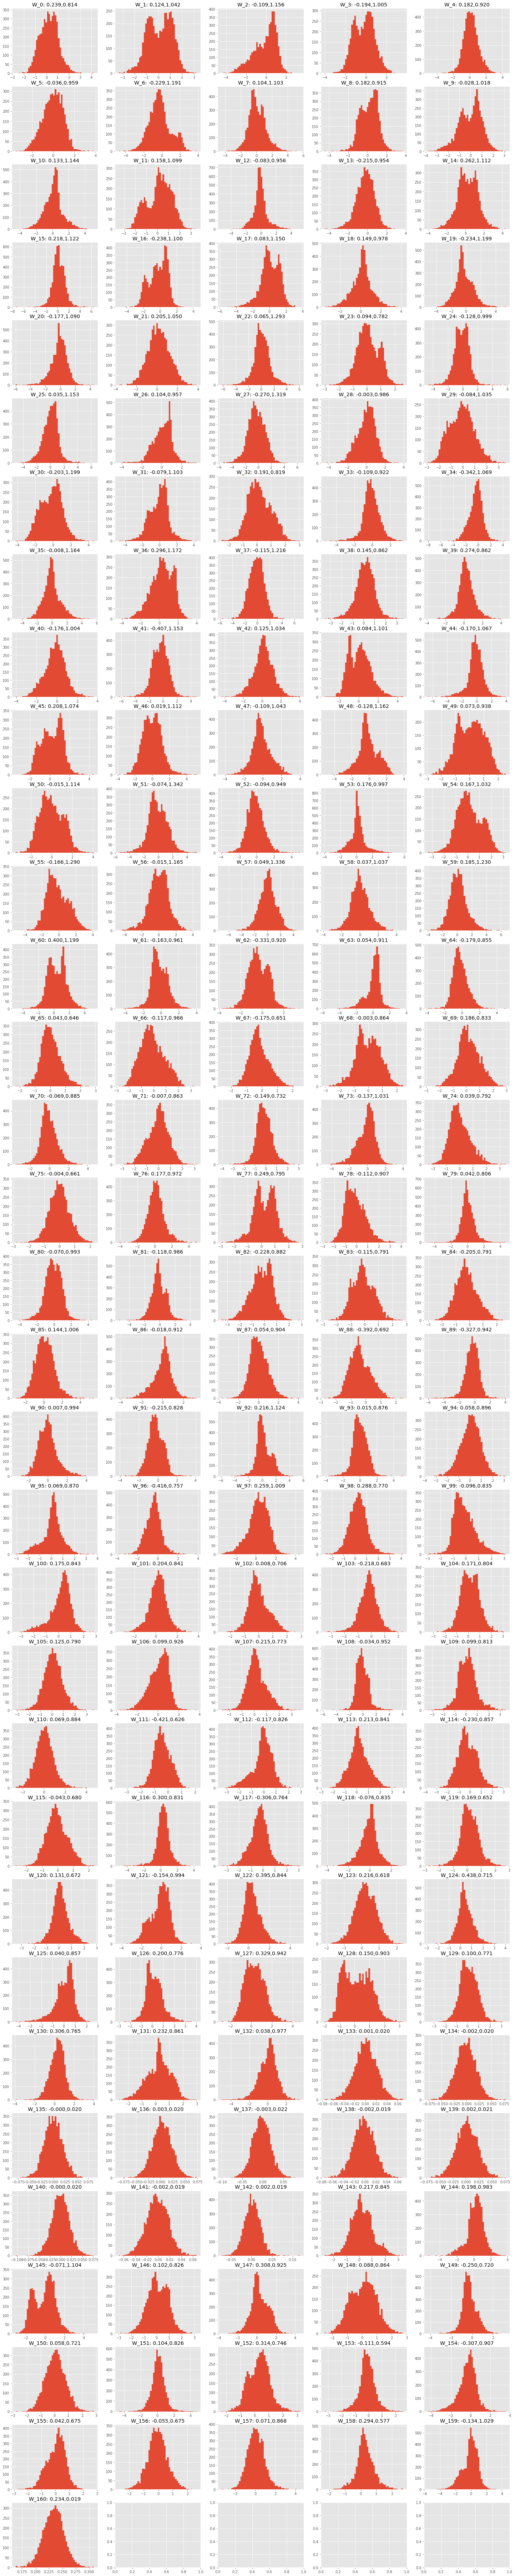

In [98]:
n_theta = outputs.shape[1]
cols = 5
rows = n_theta // cols if n_theta%cols == 0 else n_theta // cols +1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 4*rows))
#errs = []
for i in range(rows):
    for j in range(cols):
        if(i*cols+j >= n_theta):
            break
        plot_hist(outputs[:, i*cols+j], axes[i, j], 50, 'W_'+str(i*cols+j))
plt.savefig('./theta/2h-7-10-10v/'+reg_pre+'fb'+str(C)+'-'+str(J)+'-'+str(B)+'-2h-10v.png')
plt.show()

In [ ]:
def mape(y, y0):
    assert len(y) == len(y0)
    return np.mean((np.abs(np.array(y) - np.array(y0))) / np.array(y))

start_time = time.time()
res = []
for theta in outputs:
    res.append(unpack_theta_get_outputs(X_test, theta))
y_pred = np.mean(res, axis=0)
r_val = mape(Y_test, y_pred)
print('Mape Time: ', time.time() - start_time)
print('Mape Value: ', r_val)

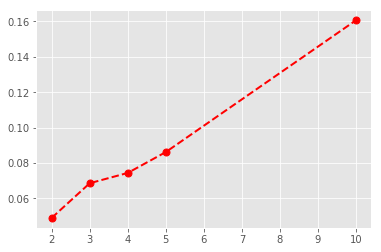

In [34]:
indexs = [2, 3, 4, 5, 10]
evals = [0.04889402, 0.06850947, 0.07433522, 0.08612559, 0.16067348]
plt.plot(indexs, evals, color='red', marker='o', linestyle='dashed',
            linewidth=2, markersize=7)
plt.show()

In [16]:
with open('./theta/fb2'+'-'+str(J)+'-'+str(B)+'-2h-10v','wb') as f:
    pickle.dump(outputs, f)

In [ ]:
rows, cols = 35, 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 4*rows))
#errs = []
for i in range(rows):
    for j in range(cols):
        mu, sigma = plot_hist(outputs[:, i*cols+j], axes[i, j], 50, 'W_'+str(i*cols+j))
        opt = cfs[i*cols+j]
        #errs.append(round(np.abs(opt - mu) / sigma, 2)) 
        axes[i,j].axvline(opt,color='red')
plt.show()

NameError: name 'plot_hist' is not defined

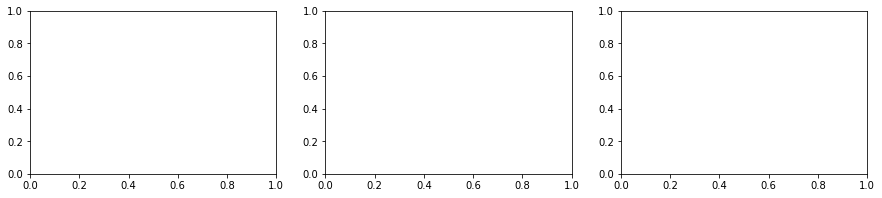

In [10]:
# for wine data
aucs = []
accs = []
f1s = []
threshold = 0.5
for W_0, W_1, W_2, b_0, b_1, b_2 in zip(qw0, qw1, qw2, qb0, qb1, qb2):
    y_pred = np_neural_network(X_test, W_0, W_1, W_2, b_0, b_1, b_2)
    aucs.append(roc_auc_score(y_test, y_pred))
    y_pred[y_pred>=threshold] = 1
    y_pred[y_pred<threshold] = 0
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    #h = np.matmul(h, W_2) + b_2
    h = sigmoid(np.matmul(h, W_2) + b_2)
    return np.reshape(h, [-1])
def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
aucs = []
accs = []
f1s = []
threshold = 0.5
for theta in outputs:
    y_pred = unpack_thete_get_outputs(X_test, theta)
    aucs.append(roc_auc_score(y_test, y_pred))
    y_pred[y_pred>=threshold] = 1
    y_pred[y_pred<threshold] = 0
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

NameError: name 'outputs' is not defined

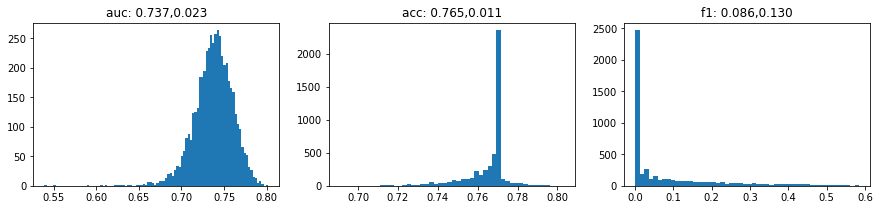

In [11]:
def plot_hist(data, ax, bins=50, title=''):
    ax.hist(data, bins=bins)
    ax.set_title(title+': '+str("%.3f" % np.mean(data))+','+str("%.3f" % np.std(data)))
    return

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plot_hist(aucs, axes[0], 100, 'auc')
plot_hist(accs, axes[1], 50, 'acc')
plot_hist(f1s, axes[2], 50, 'f1')
plt.show()

In [12]:
st = time.time()
mus = tf.stack(
    [pack_theta(qW_0.sample(), qW_1.sample(), qW_2.sample(),
              qb_0.sample(), qb_1.sample(), qb_2.sample())
    for _ in range(B)])
print('sampling time:', time.time() - st)
rt = time.time()
outputs = sess.run(mus)
print('runing time:', time.time() - rt)

sampling time: 309.859356165
runing time: 502.830904007


In [ ]:
'''print("sampleing from posterior of theta...")
start_sample = time.time()
outputs = mus.eval()
print("sampling time: ", time.time() - start_sample)
sp = []
for i in range(B):
    sp.append(roc_auc_score(y_test,outputs[i]))
    
plt.hist(sp, bins=100)
plt.show()'''

In [10]:
start_sample = time.time()
mus = tf.stack(
    [pack_theta(qW_0.sample(), qW_1.sample(), qW_2.sample(),
                       qb_0.sample(), qb_1.sample(), qb_2.sample())
    for _ in range(B)])
outputs = mus.eval()
print("sampling time: ", time.time() - start_sample)

sampling time:  514.006013155


In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    #h = np.matmul(h, W_2) + b_2
    h = sigmoid(np.matmul(h, W_2) + b_2)
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
aucs = []
accs = []
f1s = []
threshold = 0.5
for theta in outputs:
    y_pred = unpack_thete_get_outputs(X_test, theta)
    aucs.append(roc_auc_score(y_test, y_pred))
    y_pred[y_pred>=threshold] = 1
    y_pred[y_pred<threshold] = 0
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

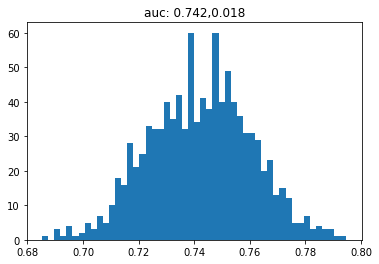

In [15]:
plt.hist(aucs, bins=50)
#plt.savefig('../aly_out/qauc'+'-'+str(J)+'-'+str(B)+'.png')
plt.title('auc: '+str("%.3f" % np.mean(aucs))+','+str("%.3f" % np.std(aucs)))
plt.show()

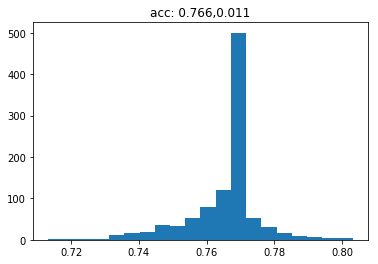

In [16]:
plt.hist(accs, bins=20)
#plt.savefig('../aly_out/qacc'+'-'+str(J)+'-'+str(B)+'.png')
plt.title('acc: '+str("%.3f" % np.mean(accs))+','+str("%.3f" % np.std(accs)))
plt.show()

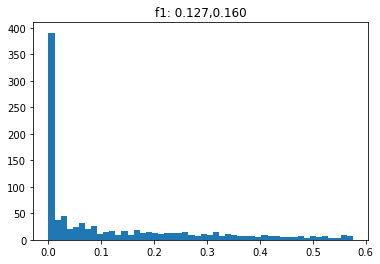

In [17]:
plt.hist(f1s, bins=50)
#plt.savefig('../aly_out/qauc'+'-'+str(J)+'-'+str(B)+'.png')
plt.title('f1: '+str("%.3f" % np.mean(f1s))+','+str("%.3f" % np.std(f1s)))
plt.show()

Text(0.5,0.98,'Joint posterior distribution of the first 5 weights')

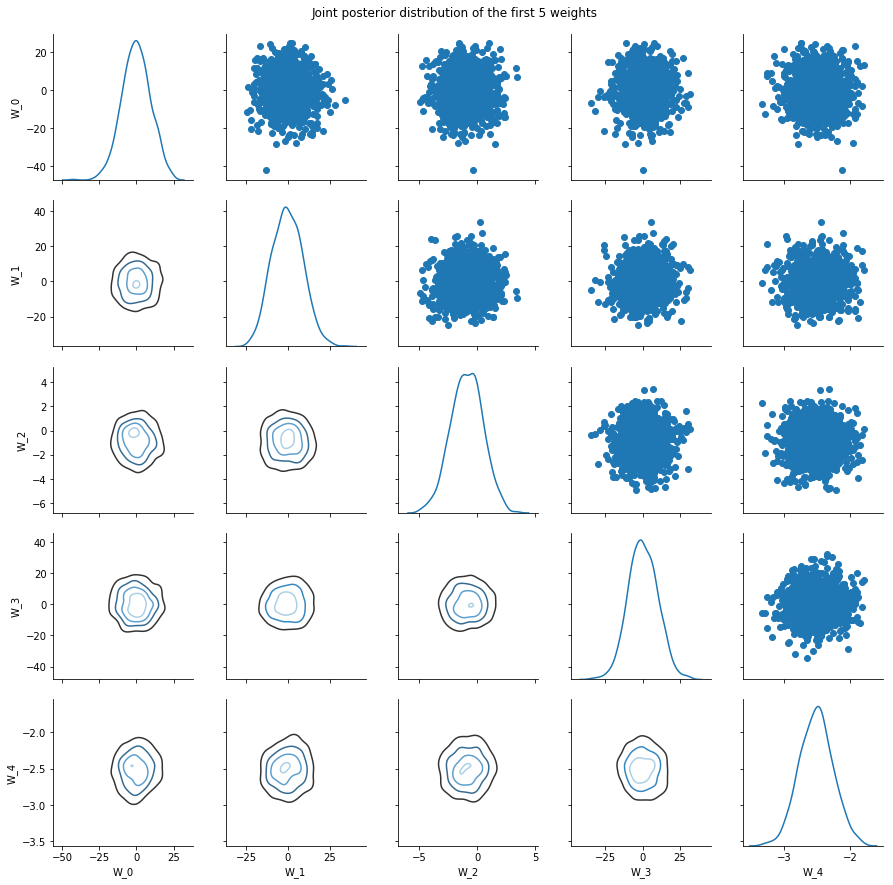

In [22]:
import seaborn as sns
# Create a Pandas DataFrame of posterior samples.
samples_df = pd.DataFrame(data = outputs, index=range(B))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

In [2]:
J = 1000
B = 500
with open('../smc2/mtheta'+'-'+str(J)+'-'+str(B)+'-2h-10v','rb') as f:
    outputs1 = np.array(pickle.load(f))

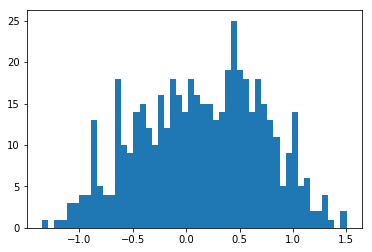

In [13]:
plt.hist(outputs1[:,1], bins=50)
plt.show()

In [ ]:
J = 10000
B = 5000
with open('../smc2/theta'+'-'+str(J)+'-'+str(B)+'-1h-1v','rb') as f:
    outputs2 = np.array(pickle.load(f))
plt.hist(outputs1[:,0])
plt.show()

In [6]:
def np_neural_network(X, W_0, W_1, b_0, b_1):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.matmul(h, W_1) + b_1
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*14], [11, 14])
    W_1 = np.reshape(theta[11*14: 11*14+14*1], [14, 1])
    b_0 = np.reshape(theta[11*14+14*1:11*14+14*1+14], [14])
    b_1 = np.reshape(theta[11*14+14*1+14:], [1])
    return np_neural_network(X, W_0, W_1, b_0, b_1)

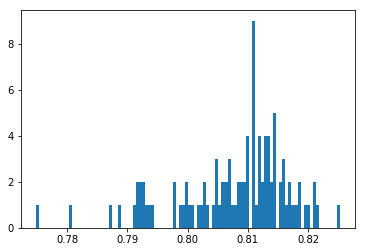

In [7]:
sp = []
for theta in outputs1:
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, theta)))
plt.hist(sp, bins=100)
plt.show()

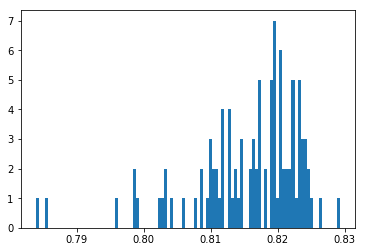

In [22]:
sp = []
for i in range(B):
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, outputs[i])))
plt.hist(sp, bins=100)
plt.show()

In [2]:
J = 10000
B = 1000
with open('../smc2/theta'+'-'+str(J)+'-'+str(B),'rb') as f:
    outputs2 = np.array(pickle.load(f))
outputs2.shape

(1000, 175)

In [7]:
def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    h = np.matmul(h, W_2) + b_2
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*7], [11, 7])
    W_1 = np.reshape(theta[11*7: 11*7+7*10], [7, 10])
    W_2 = np.reshape(theta[11*7+7*10: 11*7+7*10+10*1], [10, 1])
    bs = 11*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

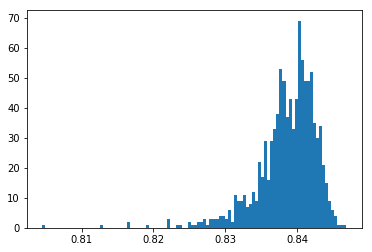

In [8]:
sp = []
for theta in outputs2:
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, theta)))
plt.hist(sp, bins=100)
plt.show()